# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

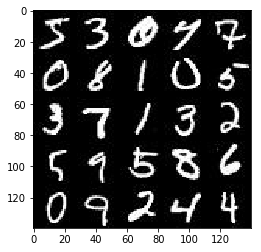

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

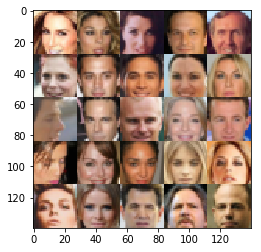

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "C:\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "C:\\Anaconda3\\lib\\site-pac

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        layer = tf.layers.conv2d(images, 64, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 14 x 14 x 64

        layer = tf.layers.conv2d(layer, 128, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 7 x 7 x 128

        layer = tf.layers.conv2d(layer, 256, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 4 x 4 x 256
        
        layer = tf.contrib.layers.flatten(layer)
        
        logits = tf.layers.dense(layer, 1)
        out = tf.sigmoid(logits)

    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):

        layer = tf.layers.dense(z, 7 * 7 * 512, use_bias=False)
        
        layer = tf.reshape(layer, (-1, 7, 7, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 7 x 7 x 1024

        layer = tf.layers.conv2d_transpose(layer, 256, 5, 2, 'SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 14 x 14 x 512

        layer = tf.layers.conv2d_transpose(layer, 128, 5, 2, 'SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 28 x 28 x 256

        layer = tf.layers.conv2d_transpose(layer, 128, 5, 1, 'SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.nn.dropout(layer, 0.8)
        # 28 x 28 x 128

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, 1, 'SAME')
        # 28 x 28 x 3

        out = tf.tanh(layer)
            
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, True, alpha)
    d_logits_real, d_model_real = discriminator(input_real, False, alpha)
    d_logits_fake, d_model_fake = discriminator(g_model, True, alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = []
    g_vars = []
    
    for var in t_vars:
        if var.name.startswith('discriminator'):
            d_vars.append(var)
        elif var.name.startswith('generator'):
            g_vars.append(var)

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    img_channels = 3 if data_image_mode == 'RGB' else 1
    _, image_width, image_height, colors = data_shape
    
    input_real, input_z, input_learning_rate = model_inputs(image_width, image_height, img_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels, 0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Step {:5}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, img_channels, data_image_mode)
        show_generator_output(sess, 9, input_z, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step    10... Discriminator Loss: 1.0664... Generator Loss: 1.2989
Epoch 1/2... Step    20... Discriminator Loss: 0.9964... Generator Loss: 1.4656
Epoch 1/2... Step    30... Discriminator Loss: 0.9681... Generator Loss: 1.5607
Epoch 1/2... Step    40... Discriminator Loss: 0.8341... Generator Loss: 1.7932
Epoch 1/2... Step    50... Discriminator Loss: 0.6994... Generator Loss: 1.9913
Epoch 1/2... Step    60... Discriminator Loss: 0.6467... Generator Loss: 2.2412
Epoch 1/2... Step    70... Discriminator Loss: 1.3757... Generator Loss: 0.9557
Epoch 1/2... Step    80... Discriminator Loss: 1.2615... Generator Loss: 1.2532
Epoch 1/2... Step    90... Discriminator Loss: 1.0764... Generator Loss: 1.4784
Epoch 1/2... Step   100... Discriminator Loss: 1.1322... Generator Loss: 1.0782


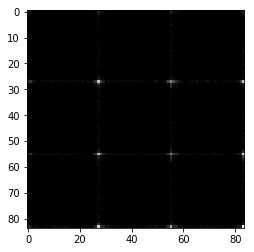

Epoch 1/2... Step   110... Discriminator Loss: 1.1531... Generator Loss: 1.2794
Epoch 1/2... Step   120... Discriminator Loss: 1.1913... Generator Loss: 1.3840
Epoch 1/2... Step   130... Discriminator Loss: 1.2008... Generator Loss: 1.2541
Epoch 1/2... Step   140... Discriminator Loss: 1.1969... Generator Loss: 1.4732
Epoch 1/2... Step   150... Discriminator Loss: 1.1399... Generator Loss: 1.3111
Epoch 1/2... Step   160... Discriminator Loss: 1.0916... Generator Loss: 1.2051
Epoch 1/2... Step   170... Discriminator Loss: 1.1376... Generator Loss: 1.0044
Epoch 1/2... Step   180... Discriminator Loss: 1.1855... Generator Loss: 1.4022
Epoch 1/2... Step   190... Discriminator Loss: 1.4697... Generator Loss: 1.2545
Epoch 1/2... Step   200... Discriminator Loss: 1.2464... Generator Loss: 1.0736


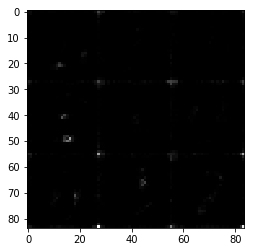

Epoch 1/2... Step   210... Discriminator Loss: 1.1113... Generator Loss: 1.3762
Epoch 1/2... Step   220... Discriminator Loss: 1.4209... Generator Loss: 0.7276
Epoch 1/2... Step   230... Discriminator Loss: 1.2819... Generator Loss: 0.8034
Epoch 1/2... Step   240... Discriminator Loss: 1.3440... Generator Loss: 0.8202
Epoch 1/2... Step   250... Discriminator Loss: 1.2877... Generator Loss: 0.9503
Epoch 1/2... Step   260... Discriminator Loss: 1.1287... Generator Loss: 1.0196
Epoch 1/2... Step   270... Discriminator Loss: 1.1979... Generator Loss: 0.8758
Epoch 1/2... Step   280... Discriminator Loss: 1.1463... Generator Loss: 1.4373
Epoch 1/2... Step   290... Discriminator Loss: 1.1817... Generator Loss: 1.0681
Epoch 1/2... Step   300... Discriminator Loss: 1.0542... Generator Loss: 1.5553


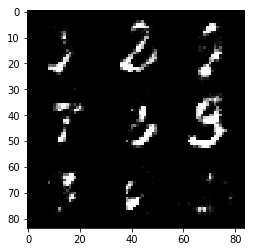

Epoch 1/2... Step   310... Discriminator Loss: 1.3004... Generator Loss: 1.6971
Epoch 1/2... Step   320... Discriminator Loss: 1.2575... Generator Loss: 1.4829
Epoch 1/2... Step   330... Discriminator Loss: 1.0977... Generator Loss: 1.0822
Epoch 1/2... Step   340... Discriminator Loss: 1.0549... Generator Loss: 1.2267
Epoch 1/2... Step   350... Discriminator Loss: 1.1589... Generator Loss: 1.1832
Epoch 1/2... Step   360... Discriminator Loss: 1.0835... Generator Loss: 1.0844
Epoch 1/2... Step   370... Discriminator Loss: 1.1569... Generator Loss: 1.3422
Epoch 1/2... Step   380... Discriminator Loss: 1.2172... Generator Loss: 1.9073
Epoch 1/2... Step   390... Discriminator Loss: 1.3010... Generator Loss: 0.7650
Epoch 1/2... Step   400... Discriminator Loss: 1.4026... Generator Loss: 0.6655


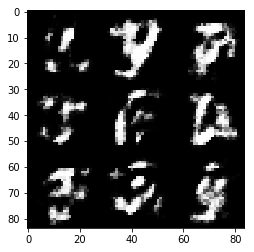

Epoch 1/2... Step   410... Discriminator Loss: 1.1102... Generator Loss: 1.7081
Epoch 1/2... Step   420... Discriminator Loss: 1.1618... Generator Loss: 1.4183
Epoch 1/2... Step   430... Discriminator Loss: 1.2108... Generator Loss: 1.5009
Epoch 1/2... Step   440... Discriminator Loss: 1.3720... Generator Loss: 1.2736
Epoch 1/2... Step   450... Discriminator Loss: 1.1813... Generator Loss: 1.4860
Epoch 1/2... Step   460... Discriminator Loss: 1.2959... Generator Loss: 2.1730
Epoch 1/2... Step   470... Discriminator Loss: 1.2680... Generator Loss: 1.8484
Epoch 1/2... Step   480... Discriminator Loss: 1.1702... Generator Loss: 1.2305
Epoch 1/2... Step   490... Discriminator Loss: 1.1676... Generator Loss: 0.9460
Epoch 1/2... Step   500... Discriminator Loss: 1.0758... Generator Loss: 1.1724


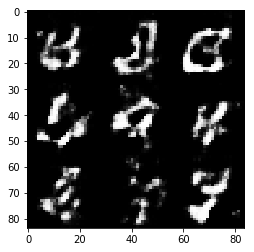

Epoch 1/2... Step   510... Discriminator Loss: 1.2270... Generator Loss: 0.9407
Epoch 1/2... Step   520... Discriminator Loss: 1.1562... Generator Loss: 0.9848
Epoch 1/2... Step   530... Discriminator Loss: 1.3185... Generator Loss: 1.0999
Epoch 1/2... Step   540... Discriminator Loss: 1.1535... Generator Loss: 1.2474
Epoch 1/2... Step   550... Discriminator Loss: 1.2972... Generator Loss: 1.5431
Epoch 1/2... Step   560... Discriminator Loss: 1.1978... Generator Loss: 1.1196
Epoch 1/2... Step   570... Discriminator Loss: 1.3724... Generator Loss: 0.6776
Epoch 1/2... Step   580... Discriminator Loss: 1.1672... Generator Loss: 1.0048
Epoch 1/2... Step   590... Discriminator Loss: 1.0821... Generator Loss: 1.6187
Epoch 1/2... Step   600... Discriminator Loss: 1.1808... Generator Loss: 1.6129


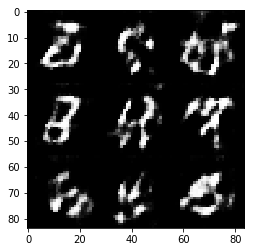

Epoch 1/2... Step   610... Discriminator Loss: 1.1833... Generator Loss: 0.9247
Epoch 1/2... Step   620... Discriminator Loss: 1.2791... Generator Loss: 1.8495
Epoch 1/2... Step   630... Discriminator Loss: 1.3494... Generator Loss: 0.9837
Epoch 1/2... Step   640... Discriminator Loss: 1.0660... Generator Loss: 1.2607
Epoch 1/2... Step   650... Discriminator Loss: 1.2470... Generator Loss: 1.2017
Epoch 1/2... Step   660... Discriminator Loss: 1.2731... Generator Loss: 1.5974
Epoch 1/2... Step   670... Discriminator Loss: 1.3319... Generator Loss: 1.0707
Epoch 1/2... Step   680... Discriminator Loss: 1.3771... Generator Loss: 0.7121
Epoch 1/2... Step   690... Discriminator Loss: 1.1825... Generator Loss: 1.1645
Epoch 1/2... Step   700... Discriminator Loss: 1.2879... Generator Loss: 1.4901


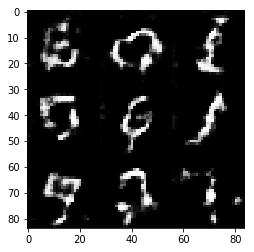

Epoch 1/2... Step   710... Discriminator Loss: 1.1498... Generator Loss: 0.7587
Epoch 1/2... Step   720... Discriminator Loss: 1.1870... Generator Loss: 1.3791
Epoch 1/2... Step   730... Discriminator Loss: 1.2331... Generator Loss: 1.2170
Epoch 1/2... Step   740... Discriminator Loss: 1.2310... Generator Loss: 1.1404
Epoch 1/2... Step   750... Discriminator Loss: 1.3476... Generator Loss: 1.1858
Epoch 1/2... Step   760... Discriminator Loss: 1.2436... Generator Loss: 0.8488
Epoch 1/2... Step   770... Discriminator Loss: 1.4214... Generator Loss: 0.7482
Epoch 1/2... Step   780... Discriminator Loss: 1.4487... Generator Loss: 1.0476
Epoch 1/2... Step   790... Discriminator Loss: 1.3174... Generator Loss: 1.4840
Epoch 1/2... Step   800... Discriminator Loss: 1.2510... Generator Loss: 1.1772


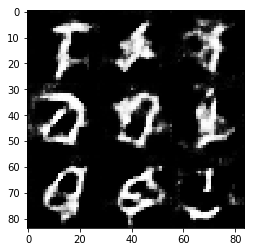

Epoch 1/2... Step   810... Discriminator Loss: 1.1208... Generator Loss: 1.0265
Epoch 1/2... Step   820... Discriminator Loss: 1.3021... Generator Loss: 1.1693
Epoch 1/2... Step   830... Discriminator Loss: 1.1342... Generator Loss: 1.1963
Epoch 1/2... Step   840... Discriminator Loss: 1.3088... Generator Loss: 1.4973
Epoch 1/2... Step   850... Discriminator Loss: 1.1903... Generator Loss: 1.3590
Epoch 1/2... Step   860... Discriminator Loss: 1.1378... Generator Loss: 1.1797
Epoch 1/2... Step   870... Discriminator Loss: 1.4055... Generator Loss: 1.2539
Epoch 1/2... Step   880... Discriminator Loss: 1.3863... Generator Loss: 1.4311
Epoch 1/2... Step   890... Discriminator Loss: 1.2864... Generator Loss: 1.0210
Epoch 1/2... Step   900... Discriminator Loss: 1.2837... Generator Loss: 1.2328


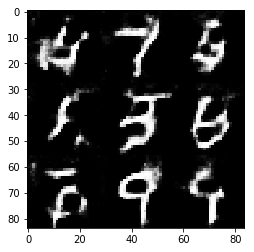

Epoch 1/2... Step   910... Discriminator Loss: 1.2558... Generator Loss: 1.1421
Epoch 1/2... Step   920... Discriminator Loss: 1.1533... Generator Loss: 0.9798
Epoch 1/2... Step   930... Discriminator Loss: 1.3381... Generator Loss: 1.2808
Epoch 2/2... Step   940... Discriminator Loss: 1.1954... Generator Loss: 0.9101
Epoch 2/2... Step   950... Discriminator Loss: 1.3041... Generator Loss: 1.1151
Epoch 2/2... Step   960... Discriminator Loss: 1.2333... Generator Loss: 0.9133
Epoch 2/2... Step   970... Discriminator Loss: 1.2292... Generator Loss: 0.9938
Epoch 2/2... Step   980... Discriminator Loss: 1.3352... Generator Loss: 0.9767
Epoch 2/2... Step   990... Discriminator Loss: 1.2184... Generator Loss: 1.1221
Epoch 2/2... Step  1000... Discriminator Loss: 1.2357... Generator Loss: 1.0945


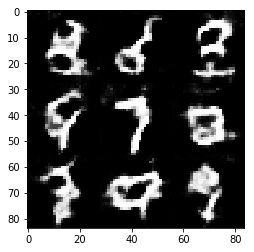

Epoch 2/2... Step  1010... Discriminator Loss: 1.2273... Generator Loss: 1.0452
Epoch 2/2... Step  1020... Discriminator Loss: 1.2326... Generator Loss: 0.9825
Epoch 2/2... Step  1030... Discriminator Loss: 1.2224... Generator Loss: 1.0436
Epoch 2/2... Step  1040... Discriminator Loss: 1.3250... Generator Loss: 1.0225
Epoch 2/2... Step  1050... Discriminator Loss: 1.2360... Generator Loss: 1.1788
Epoch 2/2... Step  1060... Discriminator Loss: 1.1541... Generator Loss: 1.1612
Epoch 2/2... Step  1070... Discriminator Loss: 1.3360... Generator Loss: 0.9097
Epoch 2/2... Step  1080... Discriminator Loss: 1.1829... Generator Loss: 1.3744
Epoch 2/2... Step  1090... Discriminator Loss: 1.0980... Generator Loss: 1.1715
Epoch 2/2... Step  1100... Discriminator Loss: 1.3035... Generator Loss: 1.1678


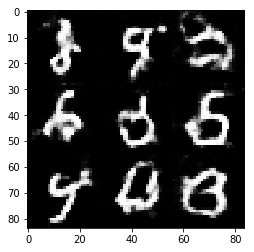

Epoch 2/2... Step  1110... Discriminator Loss: 1.1358... Generator Loss: 1.0231
Epoch 2/2... Step  1120... Discriminator Loss: 1.2396... Generator Loss: 0.9223
Epoch 2/2... Step  1130... Discriminator Loss: 1.2875... Generator Loss: 0.9079
Epoch 2/2... Step  1140... Discriminator Loss: 1.1822... Generator Loss: 1.3886
Epoch 2/2... Step  1150... Discriminator Loss: 1.2649... Generator Loss: 0.9162
Epoch 2/2... Step  1160... Discriminator Loss: 1.2599... Generator Loss: 1.3165
Epoch 2/2... Step  1170... Discriminator Loss: 1.1928... Generator Loss: 1.2080
Epoch 2/2... Step  1180... Discriminator Loss: 1.2447... Generator Loss: 1.0484
Epoch 2/2... Step  1190... Discriminator Loss: 1.2758... Generator Loss: 1.0428
Epoch 2/2... Step  1200... Discriminator Loss: 1.2655... Generator Loss: 1.1625


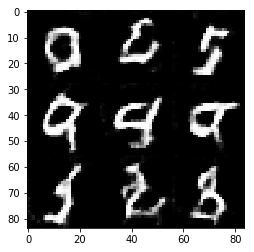

Epoch 2/2... Step  1210... Discriminator Loss: 1.1507... Generator Loss: 1.2374
Epoch 2/2... Step  1220... Discriminator Loss: 1.2377... Generator Loss: 1.2565
Epoch 2/2... Step  1230... Discriminator Loss: 1.1193... Generator Loss: 1.0112
Epoch 2/2... Step  1240... Discriminator Loss: 1.2973... Generator Loss: 1.1546
Epoch 2/2... Step  1250... Discriminator Loss: 1.2423... Generator Loss: 0.9739
Epoch 2/2... Step  1260... Discriminator Loss: 1.2211... Generator Loss: 1.4872
Epoch 2/2... Step  1270... Discriminator Loss: 1.2846... Generator Loss: 0.8598
Epoch 2/2... Step  1280... Discriminator Loss: 1.3246... Generator Loss: 0.8381
Epoch 2/2... Step  1290... Discriminator Loss: 1.2877... Generator Loss: 1.3222
Epoch 2/2... Step  1300... Discriminator Loss: 1.2824... Generator Loss: 0.8299


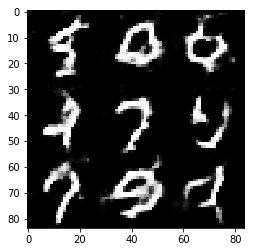

Epoch 2/2... Step  1310... Discriminator Loss: 1.2326... Generator Loss: 0.8406
Epoch 2/2... Step  1320... Discriminator Loss: 1.3032... Generator Loss: 0.9582
Epoch 2/2... Step  1330... Discriminator Loss: 1.3226... Generator Loss: 0.9593
Epoch 2/2... Step  1340... Discriminator Loss: 1.2640... Generator Loss: 1.0415
Epoch 2/2... Step  1350... Discriminator Loss: 1.2414... Generator Loss: 1.2769
Epoch 2/2... Step  1360... Discriminator Loss: 1.2621... Generator Loss: 1.0116
Epoch 2/2... Step  1370... Discriminator Loss: 1.2110... Generator Loss: 1.4620
Epoch 2/2... Step  1380... Discriminator Loss: 1.1975... Generator Loss: 0.8677
Epoch 2/2... Step  1390... Discriminator Loss: 1.2099... Generator Loss: 1.1137
Epoch 2/2... Step  1400... Discriminator Loss: 1.4256... Generator Loss: 0.6442


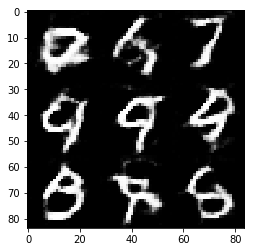

Epoch 2/2... Step  1410... Discriminator Loss: 1.2756... Generator Loss: 1.2548
Epoch 2/2... Step  1420... Discriminator Loss: 1.2613... Generator Loss: 1.0846
Epoch 2/2... Step  1430... Discriminator Loss: 1.2324... Generator Loss: 0.9053
Epoch 2/2... Step  1440... Discriminator Loss: 1.1433... Generator Loss: 1.1434
Epoch 2/2... Step  1450... Discriminator Loss: 1.2031... Generator Loss: 1.3357
Epoch 2/2... Step  1460... Discriminator Loss: 1.2298... Generator Loss: 1.3310
Epoch 2/2... Step  1470... Discriminator Loss: 1.2927... Generator Loss: 0.9181
Epoch 2/2... Step  1480... Discriminator Loss: 1.1431... Generator Loss: 0.9555
Epoch 2/2... Step  1490... Discriminator Loss: 1.1949... Generator Loss: 1.1191
Epoch 2/2... Step  1500... Discriminator Loss: 1.2757... Generator Loss: 1.0988


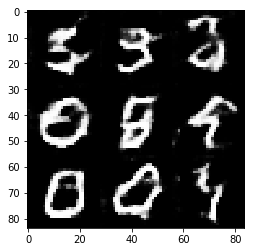

Epoch 2/2... Step  1510... Discriminator Loss: 1.1702... Generator Loss: 1.3359
Epoch 2/2... Step  1520... Discriminator Loss: 1.1068... Generator Loss: 1.0249
Epoch 2/2... Step  1530... Discriminator Loss: 1.2513... Generator Loss: 1.1446
Epoch 2/2... Step  1540... Discriminator Loss: 1.2585... Generator Loss: 1.0299
Epoch 2/2... Step  1550... Discriminator Loss: 1.2402... Generator Loss: 0.8160
Epoch 2/2... Step  1560... Discriminator Loss: 1.2140... Generator Loss: 0.9592
Epoch 2/2... Step  1570... Discriminator Loss: 1.2386... Generator Loss: 1.2075
Epoch 2/2... Step  1580... Discriminator Loss: 1.3928... Generator Loss: 1.4822
Epoch 2/2... Step  1590... Discriminator Loss: 1.2699... Generator Loss: 1.0215
Epoch 2/2... Step  1600... Discriminator Loss: 1.1201... Generator Loss: 0.9677


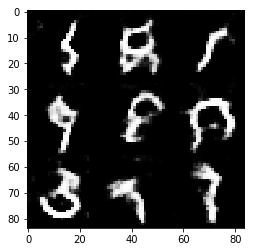

Epoch 2/2... Step  1610... Discriminator Loss: 1.2535... Generator Loss: 0.9659
Epoch 2/2... Step  1620... Discriminator Loss: 1.1897... Generator Loss: 1.0698
Epoch 2/2... Step  1630... Discriminator Loss: 1.3106... Generator Loss: 1.0836
Epoch 2/2... Step  1640... Discriminator Loss: 1.2190... Generator Loss: 0.9002
Epoch 2/2... Step  1650... Discriminator Loss: 1.1446... Generator Loss: 1.1638
Epoch 2/2... Step  1660... Discriminator Loss: 1.1800... Generator Loss: 1.0796
Epoch 2/2... Step  1670... Discriminator Loss: 1.1564... Generator Loss: 1.0850
Epoch 2/2... Step  1680... Discriminator Loss: 1.1142... Generator Loss: 1.1321
Epoch 2/2... Step  1690... Discriminator Loss: 1.1970... Generator Loss: 0.8985
Epoch 2/2... Step  1700... Discriminator Loss: 1.3753... Generator Loss: 0.6410


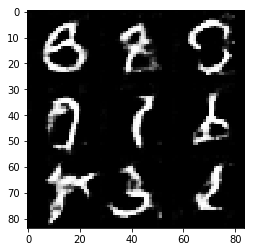

Epoch 2/2... Step  1710... Discriminator Loss: 1.2139... Generator Loss: 0.8058
Epoch 2/2... Step  1720... Discriminator Loss: 1.3111... Generator Loss: 0.7166
Epoch 2/2... Step  1730... Discriminator Loss: 1.1833... Generator Loss: 0.8078
Epoch 2/2... Step  1740... Discriminator Loss: 1.3110... Generator Loss: 1.0934
Epoch 2/2... Step  1750... Discriminator Loss: 1.2218... Generator Loss: 1.3171
Epoch 2/2... Step  1760... Discriminator Loss: 1.1835... Generator Loss: 1.0569
Epoch 2/2... Step  1770... Discriminator Loss: 1.1982... Generator Loss: 1.1976
Epoch 2/2... Step  1780... Discriminator Loss: 1.1877... Generator Loss: 0.9877
Epoch 2/2... Step  1790... Discriminator Loss: 0.9435... Generator Loss: 1.1736
Epoch 2/2... Step  1800... Discriminator Loss: 1.1766... Generator Loss: 1.4244


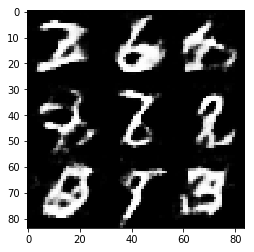

Epoch 2/2... Step  1810... Discriminator Loss: 1.3632... Generator Loss: 0.7422
Epoch 2/2... Step  1820... Discriminator Loss: 1.2276... Generator Loss: 0.8841
Epoch 2/2... Step  1830... Discriminator Loss: 1.1635... Generator Loss: 0.9307
Epoch 2/2... Step  1840... Discriminator Loss: 1.3896... Generator Loss: 0.9966
Epoch 2/2... Step  1850... Discriminator Loss: 1.2736... Generator Loss: 0.9041
Epoch 2/2... Step  1860... Discriminator Loss: 1.1571... Generator Loss: 0.8681
Epoch 2/2... Step  1870... Discriminator Loss: 1.1139... Generator Loss: 1.1282


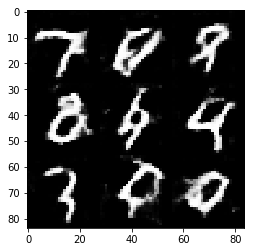

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step    10... Discriminator Loss: 0.9193... Generator Loss: 1.5821
Epoch 1/1... Step    20... Discriminator Loss: 0.7394... Generator Loss: 1.8239
Epoch 1/1... Step    30... Discriminator Loss: 0.6394... Generator Loss: 2.3571
Epoch 1/1... Step    40... Discriminator Loss: 0.7060... Generator Loss: 2.0199
Epoch 1/1... Step    50... Discriminator Loss: 0.9670... Generator Loss: 1.5183
Epoch 1/1... Step    60... Discriminator Loss: 0.6672... Generator Loss: 3.0435
Epoch 1/1... Step    70... Discriminator Loss: 0.7131... Generator Loss: 3.0795
Epoch 1/1... Step    80... Discriminator Loss: 0.7313... Generator Loss: 2.4426
Epoch 1/1... Step    90... Discriminator Loss: 0.7209... Generator Loss: 2.1491
Epoch 1/1... Step   100... Discriminator Loss: 0.6720... Generator Loss: 1.9078


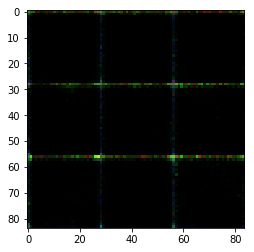

Epoch 1/1... Step   110... Discriminator Loss: 0.6455... Generator Loss: 2.1398
Epoch 1/1... Step   120... Discriminator Loss: 0.4453... Generator Loss: 3.5840
Epoch 1/1... Step   130... Discriminator Loss: 0.4382... Generator Loss: 4.0959
Epoch 1/1... Step   140... Discriminator Loss: 0.4946... Generator Loss: 2.6298
Epoch 1/1... Step   150... Discriminator Loss: 0.5431... Generator Loss: 2.7823
Epoch 1/1... Step   160... Discriminator Loss: 1.1659... Generator Loss: 4.6966
Epoch 1/1... Step   170... Discriminator Loss: 0.6244... Generator Loss: 2.2703
Epoch 1/1... Step   180... Discriminator Loss: 0.9854... Generator Loss: 1.3364
Epoch 1/1... Step   190... Discriminator Loss: 0.5285... Generator Loss: 2.5334
Epoch 1/1... Step   200... Discriminator Loss: 1.9752... Generator Loss: 5.6763


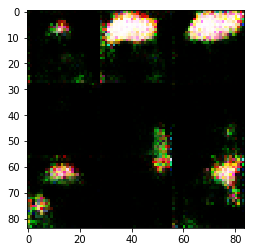

Epoch 1/1... Step   210... Discriminator Loss: 0.6908... Generator Loss: 1.7414
Epoch 1/1... Step   220... Discriminator Loss: 0.6708... Generator Loss: 2.1599
Epoch 1/1... Step   230... Discriminator Loss: 0.8914... Generator Loss: 3.3010
Epoch 1/1... Step   240... Discriminator Loss: 0.6602... Generator Loss: 2.4292
Epoch 1/1... Step   250... Discriminator Loss: 0.6149... Generator Loss: 2.4940
Epoch 1/1... Step   260... Discriminator Loss: 0.8760... Generator Loss: 2.1057
Epoch 1/1... Step   270... Discriminator Loss: 0.9106... Generator Loss: 2.1793
Epoch 1/1... Step   280... Discriminator Loss: 0.7770... Generator Loss: 1.4218
Epoch 1/1... Step   290... Discriminator Loss: 0.7958... Generator Loss: 1.6788
Epoch 1/1... Step   300... Discriminator Loss: 0.7525... Generator Loss: 1.5779


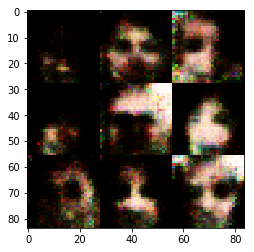

Epoch 1/1... Step   310... Discriminator Loss: 0.7700... Generator Loss: 2.1409
Epoch 1/1... Step   320... Discriminator Loss: 0.6715... Generator Loss: 2.2241
Epoch 1/1... Step   330... Discriminator Loss: 1.0146... Generator Loss: 3.3407
Epoch 1/1... Step   340... Discriminator Loss: 1.1037... Generator Loss: 2.7505
Epoch 1/1... Step   350... Discriminator Loss: 0.9141... Generator Loss: 2.0549
Epoch 1/1... Step   360... Discriminator Loss: 0.7284... Generator Loss: 1.8739
Epoch 1/1... Step   370... Discriminator Loss: 0.9443... Generator Loss: 2.9598
Epoch 1/1... Step   380... Discriminator Loss: 0.8002... Generator Loss: 2.2666
Epoch 1/1... Step   390... Discriminator Loss: 0.8691... Generator Loss: 1.3198
Epoch 1/1... Step   400... Discriminator Loss: 0.8600... Generator Loss: 1.9307


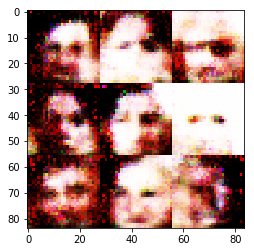

Epoch 1/1... Step   410... Discriminator Loss: 0.8914... Generator Loss: 2.4578
Epoch 1/1... Step   420... Discriminator Loss: 0.9321... Generator Loss: 1.9675
Epoch 1/1... Step   430... Discriminator Loss: 1.1226... Generator Loss: 2.5473
Epoch 1/1... Step   440... Discriminator Loss: 0.8305... Generator Loss: 1.8248
Epoch 1/1... Step   450... Discriminator Loss: 1.1729... Generator Loss: 2.5748
Epoch 1/1... Step   460... Discriminator Loss: 1.0151... Generator Loss: 1.8332
Epoch 1/1... Step   470... Discriminator Loss: 1.2031... Generator Loss: 2.4267
Epoch 1/1... Step   480... Discriminator Loss: 1.0545... Generator Loss: 1.6760
Epoch 1/1... Step   490... Discriminator Loss: 1.0489... Generator Loss: 1.1494
Epoch 1/1... Step   500... Discriminator Loss: 1.1226... Generator Loss: 1.0631


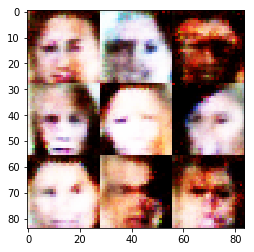

Epoch 1/1... Step   510... Discriminator Loss: 1.2436... Generator Loss: 2.4292
Epoch 1/1... Step   520... Discriminator Loss: 1.3801... Generator Loss: 0.7445
Epoch 1/1... Step   530... Discriminator Loss: 1.0750... Generator Loss: 1.4645
Epoch 1/1... Step   540... Discriminator Loss: 1.0455... Generator Loss: 1.6053
Epoch 1/1... Step   550... Discriminator Loss: 1.0224... Generator Loss: 1.7205
Epoch 1/1... Step   560... Discriminator Loss: 1.2111... Generator Loss: 1.6561
Epoch 1/1... Step   570... Discriminator Loss: 1.1327... Generator Loss: 2.0451
Epoch 1/1... Step   580... Discriminator Loss: 1.1300... Generator Loss: 1.6256
Epoch 1/1... Step   590... Discriminator Loss: 1.1321... Generator Loss: 1.0335
Epoch 1/1... Step   600... Discriminator Loss: 1.2532... Generator Loss: 1.4473


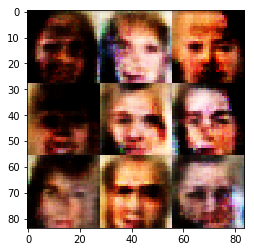

Epoch 1/1... Step   610... Discriminator Loss: 1.0171... Generator Loss: 1.6581
Epoch 1/1... Step   620... Discriminator Loss: 1.0292... Generator Loss: 1.3463
Epoch 1/1... Step   630... Discriminator Loss: 1.3500... Generator Loss: 1.9448
Epoch 1/1... Step   640... Discriminator Loss: 1.3208... Generator Loss: 1.5764
Epoch 1/1... Step   650... Discriminator Loss: 1.2678... Generator Loss: 1.5946
Epoch 1/1... Step   660... Discriminator Loss: 1.3781... Generator Loss: 0.5842
Epoch 1/1... Step   670... Discriminator Loss: 1.1429... Generator Loss: 1.1326
Epoch 1/1... Step   680... Discriminator Loss: 1.3710... Generator Loss: 1.8313
Epoch 1/1... Step   690... Discriminator Loss: 1.2406... Generator Loss: 1.6068
Epoch 1/1... Step   700... Discriminator Loss: 1.2239... Generator Loss: 1.3169


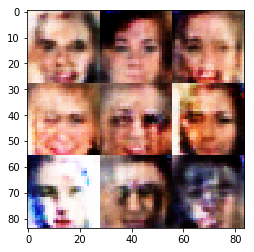

Epoch 1/1... Step   710... Discriminator Loss: 1.1278... Generator Loss: 1.0351
Epoch 1/1... Step   720... Discriminator Loss: 1.3778... Generator Loss: 1.7886
Epoch 1/1... Step   730... Discriminator Loss: 1.1214... Generator Loss: 1.1162
Epoch 1/1... Step   740... Discriminator Loss: 1.2252... Generator Loss: 0.8083
Epoch 1/1... Step   750... Discriminator Loss: 1.3256... Generator Loss: 1.2515
Epoch 1/1... Step   760... Discriminator Loss: 1.2949... Generator Loss: 1.2658
Epoch 1/1... Step   770... Discriminator Loss: 1.3724... Generator Loss: 1.3893
Epoch 1/1... Step   780... Discriminator Loss: 1.3286... Generator Loss: 1.4113
Epoch 1/1... Step   790... Discriminator Loss: 1.1783... Generator Loss: 1.2205
Epoch 1/1... Step   800... Discriminator Loss: 1.3005... Generator Loss: 1.2483


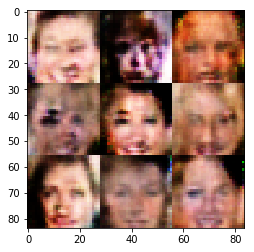

Epoch 1/1... Step   810... Discriminator Loss: 1.3508... Generator Loss: 0.6396
Epoch 1/1... Step   820... Discriminator Loss: 1.1878... Generator Loss: 1.1458
Epoch 1/1... Step   830... Discriminator Loss: 1.3249... Generator Loss: 1.0072
Epoch 1/1... Step   840... Discriminator Loss: 1.2431... Generator Loss: 1.1219
Epoch 1/1... Step   850... Discriminator Loss: 1.4305... Generator Loss: 0.8941
Epoch 1/1... Step   860... Discriminator Loss: 1.3054... Generator Loss: 0.7633
Epoch 1/1... Step   870... Discriminator Loss: 1.2380... Generator Loss: 1.2007
Epoch 1/1... Step   880... Discriminator Loss: 1.2557... Generator Loss: 1.0701
Epoch 1/1... Step   890... Discriminator Loss: 1.2684... Generator Loss: 1.0397
Epoch 1/1... Step   900... Discriminator Loss: 1.2703... Generator Loss: 1.1388


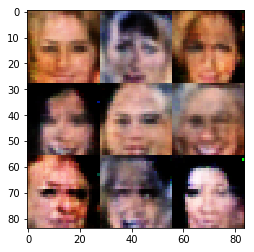

Epoch 1/1... Step   910... Discriminator Loss: 1.3395... Generator Loss: 1.1156
Epoch 1/1... Step   920... Discriminator Loss: 1.2430... Generator Loss: 1.0066
Epoch 1/1... Step   930... Discriminator Loss: 1.2325... Generator Loss: 1.1873
Epoch 1/1... Step   940... Discriminator Loss: 1.2271... Generator Loss: 1.1512
Epoch 1/1... Step   950... Discriminator Loss: 1.2035... Generator Loss: 1.3448
Epoch 1/1... Step   960... Discriminator Loss: 1.3207... Generator Loss: 1.0997
Epoch 1/1... Step   970... Discriminator Loss: 1.3437... Generator Loss: 1.3004
Epoch 1/1... Step   980... Discriminator Loss: 1.2880... Generator Loss: 0.9662
Epoch 1/1... Step   990... Discriminator Loss: 1.3274... Generator Loss: 0.9595
Epoch 1/1... Step  1000... Discriminator Loss: 1.2185... Generator Loss: 1.1983


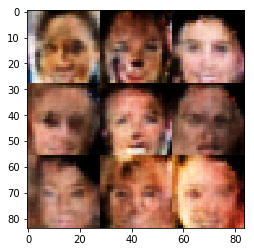

Epoch 1/1... Step  1010... Discriminator Loss: 1.2704... Generator Loss: 1.2032
Epoch 1/1... Step  1020... Discriminator Loss: 1.5131... Generator Loss: 1.7762
Epoch 1/1... Step  1030... Discriminator Loss: 1.3547... Generator Loss: 0.8808
Epoch 1/1... Step  1040... Discriminator Loss: 1.3554... Generator Loss: 1.0901
Epoch 1/1... Step  1050... Discriminator Loss: 1.2301... Generator Loss: 1.0854
Epoch 1/1... Step  1060... Discriminator Loss: 1.4530... Generator Loss: 0.7723
Epoch 1/1... Step  1070... Discriminator Loss: 1.3166... Generator Loss: 0.6608
Epoch 1/1... Step  1080... Discriminator Loss: 1.3026... Generator Loss: 1.1561
Epoch 1/1... Step  1090... Discriminator Loss: 1.4730... Generator Loss: 0.5807
Epoch 1/1... Step  1100... Discriminator Loss: 1.2392... Generator Loss: 0.9918


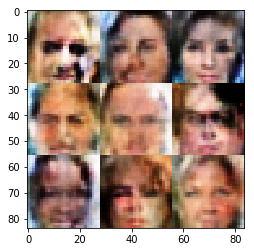

Epoch 1/1... Step  1110... Discriminator Loss: 1.2764... Generator Loss: 1.1698
Epoch 1/1... Step  1120... Discriminator Loss: 1.2793... Generator Loss: 1.0451
Epoch 1/1... Step  1130... Discriminator Loss: 1.2557... Generator Loss: 1.1932
Epoch 1/1... Step  1140... Discriminator Loss: 1.2221... Generator Loss: 1.2398
Epoch 1/1... Step  1150... Discriminator Loss: 1.4151... Generator Loss: 0.8149
Epoch 1/1... Step  1160... Discriminator Loss: 1.2493... Generator Loss: 1.0357
Epoch 1/1... Step  1170... Discriminator Loss: 1.2127... Generator Loss: 1.3911
Epoch 1/1... Step  1180... Discriminator Loss: 1.3530... Generator Loss: 1.2436
Epoch 1/1... Step  1190... Discriminator Loss: 1.4095... Generator Loss: 0.5896
Epoch 1/1... Step  1200... Discriminator Loss: 1.3480... Generator Loss: 1.2837


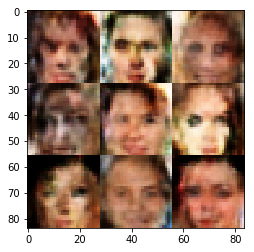

Epoch 1/1... Step  1210... Discriminator Loss: 1.3529... Generator Loss: 1.2966
Epoch 1/1... Step  1220... Discriminator Loss: 1.2756... Generator Loss: 1.3439
Epoch 1/1... Step  1230... Discriminator Loss: 1.3664... Generator Loss: 0.6475
Epoch 1/1... Step  1240... Discriminator Loss: 1.2658... Generator Loss: 1.0265
Epoch 1/1... Step  1250... Discriminator Loss: 1.2454... Generator Loss: 1.1709
Epoch 1/1... Step  1260... Discriminator Loss: 1.3652... Generator Loss: 0.8279
Epoch 1/1... Step  1270... Discriminator Loss: 1.3619... Generator Loss: 1.0757
Epoch 1/1... Step  1280... Discriminator Loss: 1.3126... Generator Loss: 1.1586
Epoch 1/1... Step  1290... Discriminator Loss: 1.3027... Generator Loss: 1.0376
Epoch 1/1... Step  1300... Discriminator Loss: 1.3002... Generator Loss: 0.7446


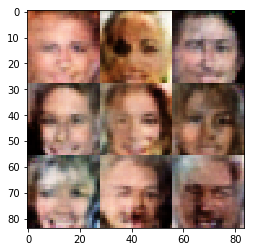

Epoch 1/1... Step  1310... Discriminator Loss: 1.3927... Generator Loss: 0.6707
Epoch 1/1... Step  1320... Discriminator Loss: 1.3403... Generator Loss: 0.9730
Epoch 1/1... Step  1330... Discriminator Loss: 1.1944... Generator Loss: 1.0731
Epoch 1/1... Step  1340... Discriminator Loss: 1.2112... Generator Loss: 0.8811
Epoch 1/1... Step  1350... Discriminator Loss: 1.3407... Generator Loss: 0.8104
Epoch 1/1... Step  1360... Discriminator Loss: 1.2303... Generator Loss: 1.0195
Epoch 1/1... Step  1370... Discriminator Loss: 1.3099... Generator Loss: 1.0391
Epoch 1/1... Step  1380... Discriminator Loss: 1.3259... Generator Loss: 1.1528
Epoch 1/1... Step  1390... Discriminator Loss: 1.2626... Generator Loss: 1.0631
Epoch 1/1... Step  1400... Discriminator Loss: 1.2353... Generator Loss: 0.9995


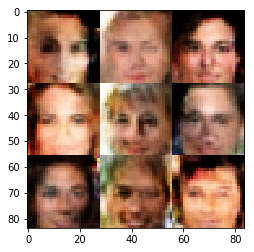

Epoch 1/1... Step  1410... Discriminator Loss: 1.3427... Generator Loss: 0.7680
Epoch 1/1... Step  1420... Discriminator Loss: 1.3738... Generator Loss: 1.1201
Epoch 1/1... Step  1430... Discriminator Loss: 1.1969... Generator Loss: 0.9329
Epoch 1/1... Step  1440... Discriminator Loss: 1.3140... Generator Loss: 1.0634
Epoch 1/1... Step  1450... Discriminator Loss: 1.3351... Generator Loss: 0.8682
Epoch 1/1... Step  1460... Discriminator Loss: 1.2761... Generator Loss: 1.2493
Epoch 1/1... Step  1470... Discriminator Loss: 1.2473... Generator Loss: 0.7884
Epoch 1/1... Step  1480... Discriminator Loss: 1.3158... Generator Loss: 0.8683
Epoch 1/1... Step  1490... Discriminator Loss: 1.2517... Generator Loss: 0.9354
Epoch 1/1... Step  1500... Discriminator Loss: 1.3965... Generator Loss: 0.7000


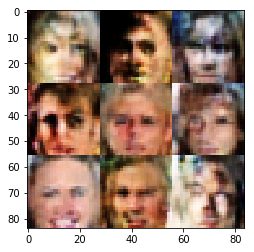

Epoch 1/1... Step  1510... Discriminator Loss: 1.2852... Generator Loss: 0.8814
Epoch 1/1... Step  1520... Discriminator Loss: 1.3246... Generator Loss: 0.9619
Epoch 1/1... Step  1530... Discriminator Loss: 1.3246... Generator Loss: 1.0048
Epoch 1/1... Step  1540... Discriminator Loss: 1.2860... Generator Loss: 1.1736
Epoch 1/1... Step  1550... Discriminator Loss: 1.3056... Generator Loss: 0.9585
Epoch 1/1... Step  1560... Discriminator Loss: 1.2212... Generator Loss: 1.0583
Epoch 1/1... Step  1570... Discriminator Loss: 1.3514... Generator Loss: 1.2132
Epoch 1/1... Step  1580... Discriminator Loss: 1.3481... Generator Loss: 0.8493
Epoch 1/1... Step  1590... Discriminator Loss: 1.2668... Generator Loss: 0.8988
Epoch 1/1... Step  1600... Discriminator Loss: 1.3171... Generator Loss: 0.9168


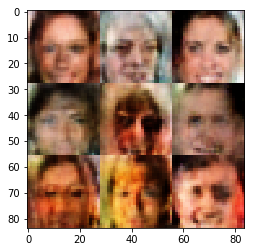

Epoch 1/1... Step  1610... Discriminator Loss: 1.3092... Generator Loss: 0.8373
Epoch 1/1... Step  1620... Discriminator Loss: 1.4392... Generator Loss: 0.6793
Epoch 1/1... Step  1630... Discriminator Loss: 1.3325... Generator Loss: 0.8332
Epoch 1/1... Step  1640... Discriminator Loss: 1.3567... Generator Loss: 0.9205
Epoch 1/1... Step  1650... Discriminator Loss: 1.3483... Generator Loss: 0.7190
Epoch 1/1... Step  1660... Discriminator Loss: 1.2908... Generator Loss: 0.8871
Epoch 1/1... Step  1670... Discriminator Loss: 1.1361... Generator Loss: 1.1111
Epoch 1/1... Step  1680... Discriminator Loss: 1.3125... Generator Loss: 0.8940
Epoch 1/1... Step  1690... Discriminator Loss: 1.3129... Generator Loss: 0.8024
Epoch 1/1... Step  1700... Discriminator Loss: 1.3038... Generator Loss: 1.0056


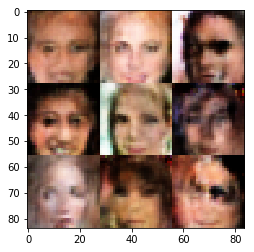

Epoch 1/1... Step  1710... Discriminator Loss: 1.2161... Generator Loss: 0.8873
Epoch 1/1... Step  1720... Discriminator Loss: 1.3285... Generator Loss: 0.8273
Epoch 1/1... Step  1730... Discriminator Loss: 1.4256... Generator Loss: 0.9339
Epoch 1/1... Step  1740... Discriminator Loss: 1.2671... Generator Loss: 1.0989
Epoch 1/1... Step  1750... Discriminator Loss: 1.2567... Generator Loss: 1.1952
Epoch 1/1... Step  1760... Discriminator Loss: 1.2158... Generator Loss: 0.9000
Epoch 1/1... Step  1770... Discriminator Loss: 1.2587... Generator Loss: 0.8902
Epoch 1/1... Step  1780... Discriminator Loss: 1.2984... Generator Loss: 1.0794
Epoch 1/1... Step  1790... Discriminator Loss: 1.3568... Generator Loss: 0.8905
Epoch 1/1... Step  1800... Discriminator Loss: 1.3796... Generator Loss: 0.6532


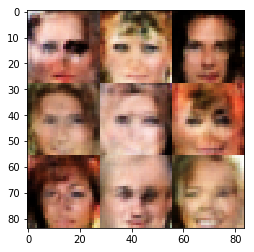

Epoch 1/1... Step  1810... Discriminator Loss: 1.3211... Generator Loss: 0.7966
Epoch 1/1... Step  1820... Discriminator Loss: 1.2809... Generator Loss: 1.0757
Epoch 1/1... Step  1830... Discriminator Loss: 1.3523... Generator Loss: 1.2479
Epoch 1/1... Step  1840... Discriminator Loss: 1.2279... Generator Loss: 1.1275
Epoch 1/1... Step  1850... Discriminator Loss: 1.2629... Generator Loss: 0.8683
Epoch 1/1... Step  1860... Discriminator Loss: 1.5512... Generator Loss: 0.6395
Epoch 1/1... Step  1870... Discriminator Loss: 1.4461... Generator Loss: 0.5988
Epoch 1/1... Step  1880... Discriminator Loss: 1.3272... Generator Loss: 0.9068
Epoch 1/1... Step  1890... Discriminator Loss: 1.3362... Generator Loss: 0.6587
Epoch 1/1... Step  1900... Discriminator Loss: 1.2725... Generator Loss: 0.8166


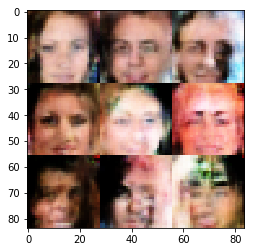

Epoch 1/1... Step  1910... Discriminator Loss: 1.3514... Generator Loss: 0.9471
Epoch 1/1... Step  1920... Discriminator Loss: 1.2574... Generator Loss: 0.9562
Epoch 1/1... Step  1930... Discriminator Loss: 1.3633... Generator Loss: 1.0313
Epoch 1/1... Step  1940... Discriminator Loss: 1.2487... Generator Loss: 0.9542
Epoch 1/1... Step  1950... Discriminator Loss: 1.3099... Generator Loss: 0.8263
Epoch 1/1... Step  1960... Discriminator Loss: 1.4478... Generator Loss: 0.9451
Epoch 1/1... Step  1970... Discriminator Loss: 1.3800... Generator Loss: 0.6126
Epoch 1/1... Step  1980... Discriminator Loss: 1.2308... Generator Loss: 0.8753
Epoch 1/1... Step  1990... Discriminator Loss: 1.3545... Generator Loss: 1.3517
Epoch 1/1... Step  2000... Discriminator Loss: 1.2827... Generator Loss: 0.9128


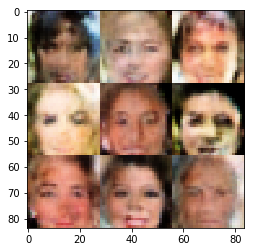

Epoch 1/1... Step  2010... Discriminator Loss: 1.3270... Generator Loss: 0.7204
Epoch 1/1... Step  2020... Discriminator Loss: 1.4581... Generator Loss: 0.6048
Epoch 1/1... Step  2030... Discriminator Loss: 1.3951... Generator Loss: 0.7604
Epoch 1/1... Step  2040... Discriminator Loss: 1.3620... Generator Loss: 1.0565
Epoch 1/1... Step  2050... Discriminator Loss: 1.3467... Generator Loss: 1.1827
Epoch 1/1... Step  2060... Discriminator Loss: 1.4028... Generator Loss: 1.0707
Epoch 1/1... Step  2070... Discriminator Loss: 1.2514... Generator Loss: 1.0374
Epoch 1/1... Step  2080... Discriminator Loss: 1.3181... Generator Loss: 0.9125
Epoch 1/1... Step  2090... Discriminator Loss: 1.4761... Generator Loss: 0.7081
Epoch 1/1... Step  2100... Discriminator Loss: 1.3165... Generator Loss: 1.2581


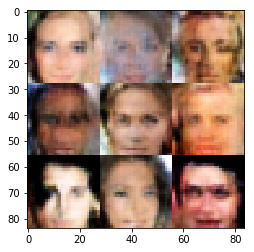

Epoch 1/1... Step  2110... Discriminator Loss: 1.3542... Generator Loss: 0.8195
Epoch 1/1... Step  2120... Discriminator Loss: 1.2620... Generator Loss: 1.0829
Epoch 1/1... Step  2130... Discriminator Loss: 1.3276... Generator Loss: 0.9814
Epoch 1/1... Step  2140... Discriminator Loss: 1.3292... Generator Loss: 0.9125
Epoch 1/1... Step  2150... Discriminator Loss: 1.2412... Generator Loss: 1.0587
Epoch 1/1... Step  2160... Discriminator Loss: 1.2995... Generator Loss: 1.0558
Epoch 1/1... Step  2170... Discriminator Loss: 1.2911... Generator Loss: 0.8181
Epoch 1/1... Step  2180... Discriminator Loss: 1.3934... Generator Loss: 0.7881
Epoch 1/1... Step  2190... Discriminator Loss: 1.3625... Generator Loss: 0.8363
Epoch 1/1... Step  2200... Discriminator Loss: 1.3408... Generator Loss: 1.0284


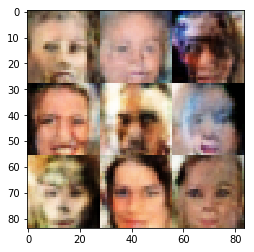

Epoch 1/1... Step  2210... Discriminator Loss: 1.3789... Generator Loss: 0.8884
Epoch 1/1... Step  2220... Discriminator Loss: 1.2732... Generator Loss: 0.8979
Epoch 1/1... Step  2230... Discriminator Loss: 1.3553... Generator Loss: 0.8384
Epoch 1/1... Step  2240... Discriminator Loss: 1.4482... Generator Loss: 0.6935
Epoch 1/1... Step  2250... Discriminator Loss: 1.2083... Generator Loss: 0.8760
Epoch 1/1... Step  2260... Discriminator Loss: 1.3956... Generator Loss: 0.9049
Epoch 1/1... Step  2270... Discriminator Loss: 1.3379... Generator Loss: 0.6817
Epoch 1/1... Step  2280... Discriminator Loss: 1.2749... Generator Loss: 1.1133
Epoch 1/1... Step  2290... Discriminator Loss: 1.2757... Generator Loss: 1.1045
Epoch 1/1... Step  2300... Discriminator Loss: 1.2167... Generator Loss: 1.1175


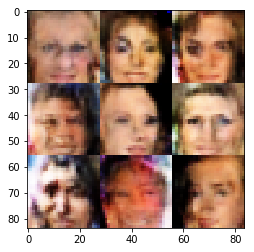

Epoch 1/1... Step  2310... Discriminator Loss: 1.2291... Generator Loss: 0.9767
Epoch 1/1... Step  2320... Discriminator Loss: 1.3098... Generator Loss: 1.0096
Epoch 1/1... Step  2330... Discriminator Loss: 1.3665... Generator Loss: 1.0451
Epoch 1/1... Step  2340... Discriminator Loss: 1.4433... Generator Loss: 1.0207
Epoch 1/1... Step  2350... Discriminator Loss: 1.3781... Generator Loss: 1.2244
Epoch 1/1... Step  2360... Discriminator Loss: 1.4415... Generator Loss: 0.8735
Epoch 1/1... Step  2370... Discriminator Loss: 1.3593... Generator Loss: 0.8417
Epoch 1/1... Step  2380... Discriminator Loss: 1.2478... Generator Loss: 0.8270
Epoch 1/1... Step  2390... Discriminator Loss: 1.2099... Generator Loss: 1.0899
Epoch 1/1... Step  2400... Discriminator Loss: 1.2485... Generator Loss: 1.1392


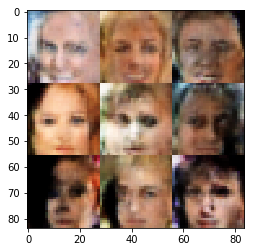

Epoch 1/1... Step  2410... Discriminator Loss: 1.3889... Generator Loss: 0.7726
Epoch 1/1... Step  2420... Discriminator Loss: 1.3860... Generator Loss: 0.8139
Epoch 1/1... Step  2430... Discriminator Loss: 1.3809... Generator Loss: 1.1901
Epoch 1/1... Step  2440... Discriminator Loss: 1.3622... Generator Loss: 0.6727
Epoch 1/1... Step  2450... Discriminator Loss: 1.3271... Generator Loss: 0.9631
Epoch 1/1... Step  2460... Discriminator Loss: 1.2769... Generator Loss: 0.8374
Epoch 1/1... Step  2470... Discriminator Loss: 1.4434... Generator Loss: 0.9529
Epoch 1/1... Step  2480... Discriminator Loss: 1.2315... Generator Loss: 0.8639
Epoch 1/1... Step  2490... Discriminator Loss: 1.2364... Generator Loss: 1.0287
Epoch 1/1... Step  2500... Discriminator Loss: 1.2853... Generator Loss: 1.0481


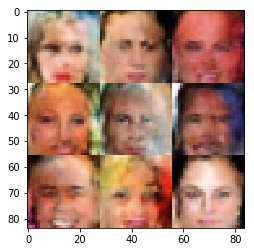

Epoch 1/1... Step  2510... Discriminator Loss: 1.3307... Generator Loss: 1.0367
Epoch 1/1... Step  2520... Discriminator Loss: 1.3027... Generator Loss: 0.9997
Epoch 1/1... Step  2530... Discriminator Loss: 1.4299... Generator Loss: 0.7962
Epoch 1/1... Step  2540... Discriminator Loss: 1.2868... Generator Loss: 0.7980
Epoch 1/1... Step  2550... Discriminator Loss: 1.4181... Generator Loss: 0.6771
Epoch 1/1... Step  2560... Discriminator Loss: 1.3451... Generator Loss: 0.9115
Epoch 1/1... Step  2570... Discriminator Loss: 1.2564... Generator Loss: 0.8771
Epoch 1/1... Step  2580... Discriminator Loss: 1.3064... Generator Loss: 1.0546
Epoch 1/1... Step  2590... Discriminator Loss: 1.3334... Generator Loss: 0.8772
Epoch 1/1... Step  2600... Discriminator Loss: 1.3566... Generator Loss: 0.8321


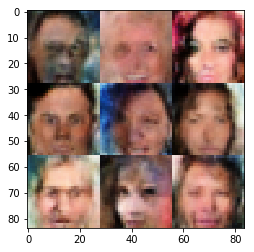

Epoch 1/1... Step  2610... Discriminator Loss: 1.3474... Generator Loss: 1.0179
Epoch 1/1... Step  2620... Discriminator Loss: 1.3311... Generator Loss: 0.9539
Epoch 1/1... Step  2630... Discriminator Loss: 1.3436... Generator Loss: 0.9037
Epoch 1/1... Step  2640... Discriminator Loss: 1.2201... Generator Loss: 1.0996
Epoch 1/1... Step  2650... Discriminator Loss: 1.2347... Generator Loss: 0.8528
Epoch 1/1... Step  2660... Discriminator Loss: 1.2778... Generator Loss: 0.9523
Epoch 1/1... Step  2670... Discriminator Loss: 1.3882... Generator Loss: 0.6602
Epoch 1/1... Step  2680... Discriminator Loss: 1.2662... Generator Loss: 1.1414
Epoch 1/1... Step  2690... Discriminator Loss: 1.3548... Generator Loss: 0.8280
Epoch 1/1... Step  2700... Discriminator Loss: 1.3587... Generator Loss: 1.2140


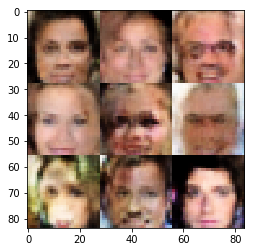

Epoch 1/1... Step  2710... Discriminator Loss: 1.4202... Generator Loss: 0.9822
Epoch 1/1... Step  2720... Discriminator Loss: 1.3548... Generator Loss: 0.7463
Epoch 1/1... Step  2730... Discriminator Loss: 1.2710... Generator Loss: 0.7697
Epoch 1/1... Step  2740... Discriminator Loss: 1.3248... Generator Loss: 0.6930
Epoch 1/1... Step  2750... Discriminator Loss: 1.3831... Generator Loss: 0.9364
Epoch 1/1... Step  2760... Discriminator Loss: 1.3751... Generator Loss: 0.8534
Epoch 1/1... Step  2770... Discriminator Loss: 1.2535... Generator Loss: 0.9347
Epoch 1/1... Step  2780... Discriminator Loss: 1.2726... Generator Loss: 0.7884
Epoch 1/1... Step  2790... Discriminator Loss: 1.4242... Generator Loss: 0.7800
Epoch 1/1... Step  2800... Discriminator Loss: 1.2840... Generator Loss: 1.0269


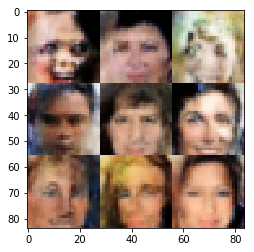

Epoch 1/1... Step  2810... Discriminator Loss: 1.3688... Generator Loss: 0.9094
Epoch 1/1... Step  2820... Discriminator Loss: 1.4050... Generator Loss: 0.8529
Epoch 1/1... Step  2830... Discriminator Loss: 1.2918... Generator Loss: 0.7509
Epoch 1/1... Step  2840... Discriminator Loss: 1.3294... Generator Loss: 0.8985
Epoch 1/1... Step  2850... Discriminator Loss: 1.3098... Generator Loss: 0.9392
Epoch 1/1... Step  2860... Discriminator Loss: 1.4007... Generator Loss: 0.9019
Epoch 1/1... Step  2870... Discriminator Loss: 1.3860... Generator Loss: 0.9307
Epoch 1/1... Step  2880... Discriminator Loss: 1.2591... Generator Loss: 1.0940
Epoch 1/1... Step  2890... Discriminator Loss: 1.3950... Generator Loss: 0.9393
Epoch 1/1... Step  2900... Discriminator Loss: 1.3690... Generator Loss: 0.9028


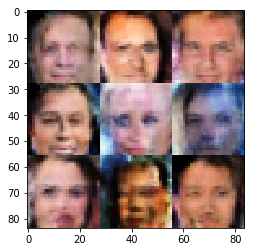

Epoch 1/1... Step  2910... Discriminator Loss: 1.3973... Generator Loss: 0.7828
Epoch 1/1... Step  2920... Discriminator Loss: 1.3632... Generator Loss: 0.9609
Epoch 1/1... Step  2930... Discriminator Loss: 1.3567... Generator Loss: 0.7211
Epoch 1/1... Step  2940... Discriminator Loss: 1.3371... Generator Loss: 0.9994
Epoch 1/1... Step  2950... Discriminator Loss: 1.3565... Generator Loss: 0.8317
Epoch 1/1... Step  2960... Discriminator Loss: 1.3977... Generator Loss: 1.0493
Epoch 1/1... Step  2970... Discriminator Loss: 1.3738... Generator Loss: 0.9683
Epoch 1/1... Step  2980... Discriminator Loss: 1.3311... Generator Loss: 0.7838
Epoch 1/1... Step  2990... Discriminator Loss: 1.3943... Generator Loss: 0.7177
Epoch 1/1... Step  3000... Discriminator Loss: 1.3710... Generator Loss: 0.6588


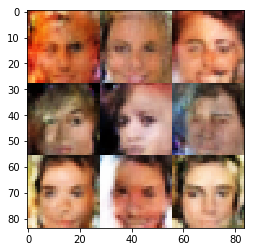

Epoch 1/1... Step  3010... Discriminator Loss: 1.2629... Generator Loss: 0.9396
Epoch 1/1... Step  3020... Discriminator Loss: 1.3753... Generator Loss: 0.8192
Epoch 1/1... Step  3030... Discriminator Loss: 1.3818... Generator Loss: 0.7536
Epoch 1/1... Step  3040... Discriminator Loss: 1.3294... Generator Loss: 1.0077
Epoch 1/1... Step  3050... Discriminator Loss: 1.4248... Generator Loss: 0.8733
Epoch 1/1... Step  3060... Discriminator Loss: 1.3888... Generator Loss: 0.8027
Epoch 1/1... Step  3070... Discriminator Loss: 1.3354... Generator Loss: 0.8182
Epoch 1/1... Step  3080... Discriminator Loss: 1.2873... Generator Loss: 0.9915
Epoch 1/1... Step  3090... Discriminator Loss: 1.2804... Generator Loss: 0.9525
Epoch 1/1... Step  3100... Discriminator Loss: 1.3964... Generator Loss: 0.9175


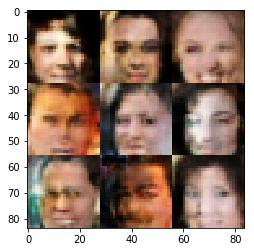

Epoch 1/1... Step  3110... Discriminator Loss: 1.3709... Generator Loss: 0.6867
Epoch 1/1... Step  3120... Discriminator Loss: 1.3228... Generator Loss: 0.8426
Epoch 1/1... Step  3130... Discriminator Loss: 1.3134... Generator Loss: 0.9698
Epoch 1/1... Step  3140... Discriminator Loss: 1.3926... Generator Loss: 0.7774
Epoch 1/1... Step  3150... Discriminator Loss: 1.3832... Generator Loss: 0.7767
Epoch 1/1... Step  3160... Discriminator Loss: 1.3818... Generator Loss: 0.6654


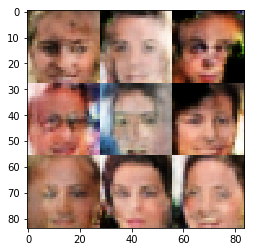

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.